In [1]:
import numpy as np
# hide numpy log warning
np.seterr(divide = 'ignore') 
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import json

from skbio import OrdinationResults
from biom import load_table
from matplotlib_venn import (venn2, venn2_unweighted)

# hide pandas Future/Deprecation Warning(s) for tutorial
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)
# plotting
plt.style.use('ggplot')
sns.set_style('white')
%matplotlib inline

## Define functions

In [2]:
def get_top_features(table, ordination, component='PC1', 
                     quantile=0.90, pseudocount=0):
    
    #get the loadings
    floadings = ordination.copy()
    floadings.rename(columns={0:"PC1", 1:"PC2", 
                              2:"PC3", 3:"PC4"}, inplace=True)
    table_df = table.copy().to_dataframe()
    top_pc_values = {}
    bottom_pc_values = {}
    beta_l = {}
    
    #sort loadings along each component
    floadings.sort_values(by=component, ascending=False, inplace=True)
    floadings_ = floadings[component].copy()
    #get top and bottom loading quantiles
    top_q = floadings_.quantile(quantile)
    bottom_q = floadings_.quantile(1-quantile)
    top_fts = floadings_[floadings_ >= top_q].index
    bottom_fts = floadings_[floadings_ <= bottom_q].index
    #aggregate the top and bottom features per sample
    num = table_df.loc[top_fts].sum(axis=0)
    num = num+pseudocount
    top_pc_values[component] = num
    
    denom = table_df.loc[bottom_fts].sum(axis=0)
    denom = denom+pseudocount
    bottom_pc_values[component] = denom
    #calculate trajectories
    beta_ = np.log(num) - np.log(denom)
    beta_l[component] = beta_

    #save top and bottom aggregated features as df
    top_fts_df = pd.DataFrame(top_pc_values, index=num.index)
    bottom_fts_df = pd.DataFrame(bottom_pc_values, index=denom.index)
    #save trajectories as df
    beta_df = pd.DataFrame(beta_l, index=num.index)
    #drop any NaN or infinity values
    beta_df = beta_df.sparse.to_dense()
    beta_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    beta_df.dropna(inplace=True)

    return (top_fts_df, bottom_fts_df, beta_df,
            top_fts.tolist(), bottom_fts.tolist())

In [3]:
def rename_feats(features_to_use, taxonomy_18s_nosp,
                 taxonomy_mag, metab_ids, tables):
    
    index_dict = {'metabolite': [], 
                  'mag': [], 
                  '18S': [], 
                  'gene_module': [],
                  'metabolomics': []}
    modality_map = {}

    for ind_ in features_to_use:
        if ind_ in taxonomy_18s_nosp.index:
            label_ = taxonomy_18s_nosp.loc[ind_, :].dropna()
            label_ = label_.values[-1] + ' (' + label_.index[-1] + ')'
            index_dict['18S'].append((ind_, label_))
            modality_map[label_] = 'Eukaryotes (18S)'

        elif ind_ in taxonomy_mag.index:
            label_ = taxonomy_mag.loc[ind_, :].dropna()
            label_ = label_.values[-1] + ' (' + label_.index[-1] + ')'
            index_dict['mag'].append((ind_, label_))
            modality_map[label_] = 'Bacterial Genomes (MetaG)'
            
        elif ind_ in metab_ids.index:
            label_ = metab_ids.loc[ind_, 'most specific class']
            index_dict['metabolite'].append((ind_, label_))
            modality_map[label_] = 'Metabolites'
            
        else:
            if ind_ in tables['mag'].ids('observation'):
                index_dict['mag'].append((ind_, ind_))
                modality_map[ind_] = 'Bacterial Genomes (MetaG)'
            elif ind_ in tables['18S'].ids('observation'):
                index_dict['18S'].append((ind_, ind_))
                modality_map[ind_] = 'Eukaryotes (18S)'
            elif ind_ in tables['gene_module'].ids('observation'):
                index_dict['gene_module'].append((ind_, ind_))
                modality_map[ind_] = 'Functions (MetaG)'
            elif ind_ in tables['metabolomics'].ids('observation'):
                index_dict['metabolomics'].append((ind_, ind_))
                modality_map[ind_] = 'Metabolites'

    #clean lists in index_dict
    for modality, feature in index_dict.items():
        #clean_lst = ['drop' if len(str(i_)) == 0 else i_ for i_ in feature]
        #clean_lst = ['drop' if str(i_) == 'nan' else i_ for i_ in clean_lst]
        clean_lst = [(i_[0], i_[1].replace('_',' ')) for i_ in feature]
        #drop features
        index_dict[modality] = [i_ for i_ in clean_lst if i_ != 'drop']

    return index_dict

## Load data

In [ ]:
# #load rpca results
# nPCs = 4
# ord_18S = OrdinationResults.read('../results/joint-rpca/Ordinations/18S_ord_{}PCs.txt'.format(nPCs))
# ord_mag = OrdinationResults.read('../results/joint-rpca/Ordinations/mag_ord_{}PCs.txt'.format(nPCs))
# ord_gene = OrdinationResults.read('../results/joint-rpca/Ordinations/gene_ord_{}PCs.txt'.format(nPCs))
# ord_gene_module = OrdinationResults.read('../results/joint-rpca/Ordinations/gene_module_ord_{}PCs.txt'.format(nPCs))
# ord_metabolite = OrdinationResults.read('../results/joint-rpca/Ordinations/metabolite_ord_{}PCs.txt'.format(nPCs))
# #load joint-rpca results
# ord_joint = OrdinationResults.read('../results/joint-rpca/Ordinations/joint_ord_{}PCs.txt'.format(nPCs))
# #load shared metadata
# metadata = pd.read_csv('../network/split-matched-data/metadata_knn.tsv', index_col=0, sep='\t')

In [4]:
# import the rest
all_tables = {'18S':'../network/split-matched-data/18S.biom',
              'mag':'../network/split-matched-data/mag.biom',
              'gene':'../network/split-matched-data/gene.biom',
              'gene_module':'../network/split-matched-data/gene_module.biom',
              'metabolite':'../network/split-matched-data/metabolite.biom',
              'metabolomics':'../network/split-matched-data/metabolomics.biom'}

tables = {}
for tbl_id, tbl_path in all_tables.items():
    tables[tbl_id] = load_table(tbl_path)

In [5]:
# annots for tables
taxonomy_18s = pd.read_csv('../network/annotations/18S_taxonomy.tsv', sep='\t', index_col=0)
taxonomy_18s = {k:{z.split('__')[0]:z.split('__')[-1]
               for z in x.split(';')} for k, x in zip(taxonomy_18s.index, taxonomy_18s.Taxon.values)}
taxonomy_18s = pd.DataFrame(taxonomy_18s).T
taxonomy_18s_nosp = taxonomy_18s.drop([' s'], axis=1)

taxonomy_mag = pd.read_csv('../network/annotations/MAG_taxonomy.tsv', sep='\t', index_col=0)
taxonomy_mag = {k:{z.split('__')[0]:z.split('__')[-1]
               for z in x.split(';')} for k, x in zip(taxonomy_mag.index, taxonomy_mag.Taxon.values)}
taxonomy_mag = pd.DataFrame(taxonomy_mag).T
taxonomy_mag[taxonomy_mag == ''] = np.nan

metab_ids = pd.read_excel('../network/metabolite_formulas.xlsx', index_col=0)
metab_ids.index = ['metab_' + str(x) for x in metab_ids.index]
metab_ids_class = metab_ids.dropna(subset=['most specific class'])

In [ ]:
# bt_tmp, df_tmp, ord_tmp = tables['metabolite']
# keep_metab = set(metab_ids_class.index) & set(bt_tmp.ids('observation'))
# bt_tmp = bt_tmp.filter(keep_metab, axis='observation')
# df_tmp = df_tmp.loc[list(keep_metab), :]
# ord_tmp = ord_tmp.loc[list(keep_metab), :].sort_values(by=axis_use)
# tables['metabolite'] = [bt_tmp, df_tmp, ord_tmp]

In [ ]:
# #retrieve feature loadings from joint-rpca
# joint_features = ord_joint.features

# #for 18S, need to make sure features are in the original table
# not_in_ord_18S = []
# in_ord_18S = []

# for id in tables['18S'].ids(axis='observation'):
#     if id not in joint_features.index:
#         not_in_ord_18S.append(id)
#     else:
#         in_ord_18S.append(id)
# print("Not in ordination results: %i" % len(not_in_ord_18S))
# print("In ordination results: %i" % len(in_ord_18S))

# #keep only common features
# tables['18S'] = tables['18S'].filter(ids_to_keep=in_ord_18S, axis='observation')

## Find overlapping features

In [ ]:
pc_ratio = {}

for task in ['facility', 'stage', 'season']:
    acc_task = pd.DataFrame(columns=['Omic', 'Fold', 'Accuracy',
                                     'Report', 'Optimization', 'PC'])
    for pc in ['PC1','PC2','PC3','PC4']:
        #load results
        acc_ratio = pd.read_csv('../results/joint-rpca/RF/rf_acc_{}-ratio_{}_4PCs.csv'.format(pc, task))
        #acc_ratio = pd.read_csv('../results/joint-rpca/KNN/knn_acc_{}-ratio_{}.tsv'.format(pc, task),
        #                        sep='\t', index_col=0)
        #add PC column
        acc_ratio['PC'] = pc
        #save results
        acc_task = acc_task._append(acc_ratio, ignore_index=True)
    
    pc_ratio[task] = acc_task

In [ ]:
best_pc_per_task = {}

for task in ['facility', 'stage', 'season']:
    #Find the median accuracy across folds for each modality and PC
    median_values = pc_ratio[task].groupby(['Omic', 'PC']).median(numeric_only=True)
    median_values = median_values.reset_index()

    #Find the PC with the maximum value for each Omic
    max_pc_per_omic = median_values.loc[median_values.groupby('Omic')['Accuracy'].idxmax()]

    #Store results in dictionary
    result_dict = max_pc_per_omic.set_index('Omic').apply(tuple, axis=1).to_dict()
    best_pc_per_task[task] = result_dict

In [ ]:
#define parameters
quantile = 0.90
task = 'stage' #'season', 'facility', 'stage'
best_pc = best_pc_per_task[task]
best_pc

In [ ]:
#find top/bottom features from individual RPCA results
rpca_ord = {'18S_RPCA': ord_18S, 'MAG_RPCA': ord_mag, 'Gene_RPCA': ord_gene, 
            'Gene_Module_RPCA': ord_gene_module, 'Metabolite_RPCA': ord_metabolite}

rpca_top_fts = {}
rpca_bot_fts = {}

for omic_pc, omic_table in zip(rpca_ord.keys(), tables.keys()):
    #sanity check
    print(omic_table, omic_pc)
    pc_to_use = best_pc[omic_pc][0]
    ord_ = rpca_ord[omic_pc].features.copy()
    table_ = tables[omic_table]
    _, _, _, top_fts, bottom_fts = get_top_features(table_, ord_, component=pc_to_use,
                                                    quantile=quantile, pseudocount=0)
    rpca_top_fts[omic_pc] = top_fts
    rpca_bot_fts[omic_pc] = bottom_fts

In [ ]:
#find top features from joint-RPCA results
joint_pc_ids = ['{}_Joint-RPCA'.format(id.split('_')[0]) if 'Module' not in id else 'Gene_Module_Joint-RPCA'
                for id in rpca_ord.keys()]
joint_top_fts = {}
joint_bot_fts = {}

for omic_pc, omic_table in zip(joint_pc_ids, tables.keys()):
    #sanity check
    print(omic_table, omic_pc)
    pc_to_use = best_pc[omic_pc][0]
    table_ = tables[omic_table]
    if omic_table == '18S':
        ord_ = joint_features.loc[in_ord_18S]
    else:
        ord_ = joint_features.loc[table_.ids(axis='observation')]

    _, _, _, top_fts, bottom_fts = get_top_features(table_, ord_, component=pc_to_use,
                                                    quantile=quantile, pseudocount=0)
    joint_top_fts[omic_pc] = top_fts
    joint_bot_fts[omic_pc] = bottom_fts

In [ ]:
#RCPA TOP and Joint-RPCA TOP intersecting features
common_top_fts = {}
for omic_rpca, omic_joint, omic_id in zip(rpca_ord.keys(), joint_pc_ids, tables.keys()):
    common_fts = set(rpca_top_fts[omic_rpca]).intersection(joint_top_fts[omic_joint])
    common_top_fts[omic_id] = common_fts
    print("Total features: %i. Number of intersecting features for %s: %i" % (len(joint_top_fts[omic_joint]), omic_id, len(common_fts)))

In [ ]:
#RCPA TOP and Joint-RPCA BOTTOM intersecting features
common_top_fts2 = {}
for omic_rpca, omic_joint, omic_id in zip(rpca_ord.keys(), joint_pc_ids, tables.keys()):
    common_fts = set(rpca_top_fts[omic_rpca]).intersection(joint_bot_fts[omic_joint])
    common_top_fts2[omic_id] = common_fts
    print("Total features: %i. Number of intersecting features for %s: %i" % (len(joint_top_fts[omic_joint]), omic_id, len(common_fts)))

In [ ]:
#RCPA BOTTOM and Joint-RPCA BOTTOM intersecting features
common_bottom_fts = {}
for omic_rpca, omic_joint, omic_id in zip(rpca_ord.keys(), joint_pc_ids, tables.keys()):
    common_fts = set(rpca_bot_fts[omic_rpca]).intersection(joint_bot_fts[omic_joint])
    common_bottom_fts[omic_id] = common_fts
    print("Total features: %i. Number of intersecting features for %s: %i" % (len(joint_bot_fts[omic_joint]), omic_id, len(common_fts)))

In [ ]:
#RCPA BOTTOM and Joint-RPCA TOP intersecting features
common_bottom_fts2 = {}
for omic_rpca, omic_joint, omic_id in zip(rpca_ord.keys(), joint_pc_ids, tables.keys()):
    common_fts = set(rpca_bot_fts[omic_rpca]).intersection(joint_top_fts[omic_joint])
    common_bottom_fts2[omic_id] = common_fts
    print("Total features: %i. Number of intersecting features for %s: %i" % (len(joint_bot_fts[omic_joint]), omic_id, len(common_fts)))

In [ ]:
#find intersecting bottom features
common_top_bot_fts = {}
for omic_rpca, omic_joint, omic_id in zip(rpca_ord.keys(), joint_pc_ids, tables.keys()):
    rpca_top_bot = set(rpca_top_fts[omic_rpca]).union(set(rpca_bot_fts[omic_rpca]))
    joint_top_bot = set(joint_top_fts[omic_joint]).union(set(joint_bot_fts[omic_joint]))
    common_fts = set(rpca_top_bot).intersection(joint_top_bot)
    common_top_bot_fts[omic_id] = common_fts
    print("Total features: %i. Number of intersecting features for %s: %i" % (len(rpca_top_bot), omic_id, len(common_fts)))

## Plotting

In [ ]:
#find the average ranks of the intersecting features
avg_ranks_common_top = {}
avg_ranks_common_bottom = {}

for omic_rpca, omic_joint, omic_id in zip(rpca_ord.keys(), joint_pc_ids, tables.keys()):
    top_ranks_rpca = []
    top_ranks_joint = []

    bottom_ranks_rpca = []
    bottom_ranks_joint = []

    for ft in common_top_bot_fts[omic_id]:

        #check rank in rpca
        if ft in rpca_top_fts[omic_rpca]:
            r_rpca = rpca_top_fts[omic_rpca].index(ft) + 1
            top_ranks_rpca.append(r_rpca)
        elif ft in rpca_bot_fts[omic_rpca]:
            r_rpca = rpca_bot_fts[omic_rpca].index(ft) + 1
            bottom_ranks_rpca.append(r_rpca)

        #check rank in joint-rpca
        if ft in joint_top_fts[omic_joint]:
            r_joint = joint_top_fts[omic_joint].index(ft) + 1
            top_ranks_joint.append(r_rpca)
        elif ft in joint_bot_fts[omic_joint]:
            r_joint = joint_bot_fts[omic_joint].index(ft) + 1
            bottom_ranks_joint.append(r_rpca)
        
    avg_ranks_common_top[omic_id] = (np.mean(top_ranks_rpca), 
                              np.mean(top_ranks_joint))
    avg_ranks_common_bottom[omic_id] = (np.mean(bottom_ranks_rpca), 
                                 np.mean(bottom_ranks_joint))

In [ ]:
avg_ranks_top_rpca_only = {}
avg_ranks_bottom_rpca_only = {}

for omic_rpca, omic_id in zip(rpca_ord.keys(), tables.keys()):
    ranks_top_rpca_only = []
    ranks_bot_rpca_only = []

    #get features unique to RPCA 
    rpca_only_top = set(rpca_top_fts[omic_rpca]) - set(common_top_bot_fts[omic_id])
    rpca_only_bot = set(rpca_bot_fts[omic_rpca]) - set(common_top_bot_fts[omic_id])
    print("Number of features unique to RPCA for %s: %i" % (omic_id, len(rpca_only_top)+len(rpca_only_bot)))
    for ft in rpca_only_top:
        r_rpca = rpca_top_fts[omic_rpca].index(ft) + 1
        ranks_top_rpca_only.append(r_rpca)
    
    for ft in rpca_only_bot:
        r_rpca = rpca_bot_fts[omic_rpca].index(ft) + 1
        ranks_bot_rpca_only.append(r_rpca)
        
    avg_ranks_top_rpca_only[omic_id] = np.mean(ranks_top_rpca_only)
    avg_ranks_bottom_rpca_only[omic_id] = np.mean(ranks_bot_rpca_only)

In [ ]:
avg_ranks_top_joint_only = {}
avg_ranks_bottom_joint_only = {}

for omic_joint, omic_id in zip(joint_pc_ids, tables.keys()):
    ranks_top_joint_only = []
    ranks_bot_joint_only = []

    #get features unique to RPCA 
    joint_only_top = set(joint_top_fts[omic_joint]) - set(common_top_bot_fts[omic_id])
    joint_only_bot = set(joint_bot_fts[omic_joint]) - set(common_top_bot_fts[omic_id])
    print("Number of features unique to Joint-RPCA for %s: %i" % (omic_id, len(joint_only_top)+len(joint_only_bot)))
    for ft in joint_only_top:
        r_joint = joint_top_fts[omic_joint].index(ft) + 1
        ranks_top_joint_only.append(r_joint)
    
    for ft in joint_only_bot:
        r_joint = joint_bot_fts[omic_joint].index(ft) + 1
        ranks_bot_joint_only.append(r_joint)
        
    avg_ranks_top_joint_only[omic_id] = np.mean(ranks_top_joint_only)
    avg_ranks_bottom_joint_only[omic_id] = np.mean(ranks_bot_joint_only)

In [ ]:
#plot a venn diagram per omic
fig, axn = plt.subplots(1, 5, figsize=(20, 5))
for ax_, omic_id, omic_rpca, omic_joint in zip(axn.flatten(), tables.keys(),
                                               rpca_ord.keys(), joint_pc_ids):
    
    rpca_top_bot = set(rpca_top_fts[omic_rpca]).union(set(rpca_bot_fts[omic_rpca]))
    joint_top_bot = set(joint_top_fts[omic_joint]).union(set(joint_bot_fts[omic_joint]))
                                                         
    a = len(rpca_top_bot) - len(common_top_bot_fts[omic_id])
    b = len(common_top_bot_fts[omic_id])
    c = len(joint_top_bot) - len(common_top_bot_fts[omic_id])

    venn2(subsets=(a, c, b), set_labels=('RPCA', 'Joint-RPCA'), ax=ax_,
          set_colors=('tab:purple', 'tab:blue'), alpha=0.5)
    ax_.set_title(omic_id)
    plt.suptitle('Intersection of key features for {} classification'.format(task), 
                 fontsize=16, y=0.8)
#plt.tight_layout()
plt.show()

In [ ]:
#create table with top and bottom ranks
#Common features: avg_ranks_common_top, avg_ranks_common_bottom
#RPCA only: avg_ranks_top_rpca_only, avg_ranks_bottom_rpca_only
#Joint-RPCA only: avg_ranks_top_joint_only, avg_ranks_bottom_joint_only

#top ranks
top_ranks = pd.DataFrame(columns=['Omic', 'RPCA Only', 'RPCA Common', 
                                  'Joint-RPCA Common', 'Joint-RPCA Only'])
for omic_id in tables.keys():
    top_ranks = top_ranks._append({'Omic': omic_id, 
                                   'RPCA Only': round(avg_ranks_top_rpca_only[omic_id], 2),
                                   'RPCA Common': round(avg_ranks_common_top[omic_id][0], 2),
                                   'Joint-RPCA Common': round(avg_ranks_common_top[omic_id][1], 2),
                                   'Joint-RPCA Only': round(avg_ranks_top_joint_only[omic_id], 2)}, 
                                   ignore_index=True)
top_ranks.set_index('Omic', inplace=True)

#bottom ranks
bottom_ranks = pd.DataFrame(columns=['Omic', 'RPCA Only', 'RPCA Common', 
                                     'Joint-RPCA Common', 'Joint-RPCA Only'])
for omic_id in tables.keys():
    bottom_ranks = bottom_ranks._append({'Omic': omic_id, 
                                         'RPCA Only': round(avg_ranks_bottom_rpca_only[omic_id], 2),
                                         'RPCA Common': round(avg_ranks_common_bottom[omic_id][0], 2),
                                         'Joint-RPCA Common': round(avg_ranks_common_bottom[omic_id][1], 2),
                                         'Joint-RPCA Only': round(avg_ranks_bottom_joint_only[omic_id], 2)}, 
                                         ignore_index=True)
bottom_ranks.set_index('Omic', inplace=True)


In [ ]:
print("Ranks of top features:")
display(top_ranks.T)
print()
print("Ranks of bottom features:")
display(bottom_ranks.T)

## RPCA and Joint-RPCA
Top 20 and bottom 20 features

In [6]:
#load json files
with open('../results/joint-rpca/Original/joint_decomposer_feats_test.json', 'r') as f:
    joint_feats = json.load(f)

with open('../results/joint-rpca/Original/rpca_decomposer_feats_test.json', 'r') as f:
    rpca_feats = json.load(f)

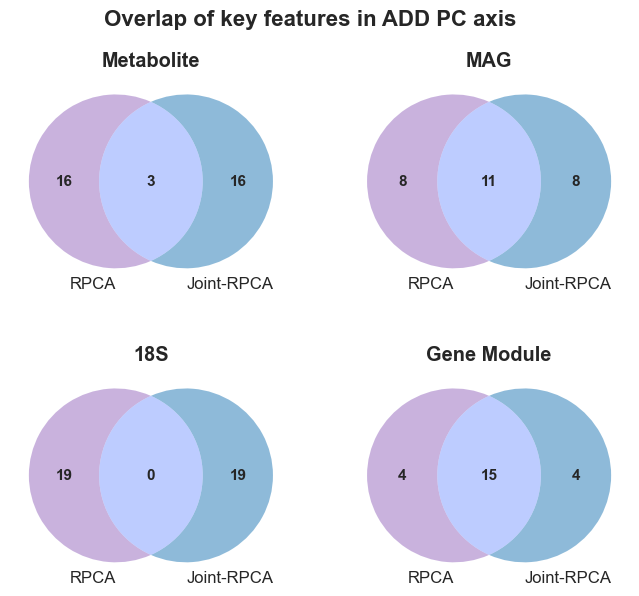

Overlapping features:
{'metabolite': {'metab_150', 'metab_443', 'metab_2750'}, 'mag': {'SHSU.bins.175', 'UTK.bins.71', 'CMU_advanced.final.11', 'SHSU.bins.319', 'CMU.bins.224', 'CMU.bins.248', 'UTK_active.final.26', 'UTK.bins.19', 'UTK.bins.50', 'SHSU_advanced.final.35', 'SHSU.bins.42'}, '18S': set(), 'gene_module': {'Arginine/lysine/histidine/glutamine_transport_system', 'Taurine_transport_system', 'Trehalose_transport_system', 'Na_-transporting_0DH:ubiquinone_oxidoreductase-', 'D0_polymerase_II_complex_archaea', 'RNF_complex', 'Universal_Cas_proteins', 'Arginine/ornithine_transport_system', '0DH:ubiquinone_oxidoreductase_mitochondria', 'Cytochrome_o_ubiquinol_oxidase', 'Adhesin_protein_transport_system', 'Type_I_signiture_cas_proteins', 'D-Methionine_transport_system', 'Tyrosine_biosynthesis_prephanate_to_pretyrosine_to_tyrosine', 'Putrescine_transport_system'}}


In [7]:
#plot a venn diagram per omic
omic_title = {'18S': '18S', 'mag': 'MAG', 
              'gene_module': 'Gene Module', 'metabolite': 'Metabolite'}
overlap_feats_omic = {}
#define direction for each omic
#e.g. num features = advanced, denom features = initial 
direction = {'18S': 1, 'mag': 1,
             'gene_module': 1, 'metabolite': 1}

#RPCA
fig, axn = plt.subplots(2, 2, figsize=(8, 7))

for ax_, omic_id in zip(axn.flatten(), joint_feats.keys()):
    
    ##check overlap between
    rpca_dir = direction[omic_id]
    rpca_feats_all = rpca_feats[omic_id][1]
    joint_feats_all = joint_feats[omic_id][0]

    overlap_feats = set(rpca_feats_all).intersection(set(joint_feats_all))
    overlap_feats_omic[omic_id] = overlap_feats
                                                         
    a = len(rpca_feats_all) - len(overlap_feats)
    b = len(overlap_feats)
    c = len(joint_feats_all) - len(overlap_feats)

    v = venn2_unweighted(subsets=(a, c, b), set_labels=('RPCA', 'Joint-RPCA'), ax=ax_,
                         set_colors=('tab:purple', 'tab:blue'), alpha=0.5)
    
    for text in v.set_labels:
       text.set_fontsize(12)
       #text.set_fontweight('bold')
    
    for text in v.subset_labels:
       text.set_fontsize(11)
       text.set_fontweight('bold')

    ax_.set_title(omic_title[omic_id], weight='bold')
    plt.suptitle('Overlap of key features in ADD PC axis', 
                 fontsize=16, x=0.5, y=0.95, fontweight='bold')

#plt.savefig('../results/joint-rpca/Figures/rpca-venns.pdf', 
#           dpi=600, bbox_inches='tight', format='pdf')
plt.show()

print("Overlapping features:")
print(overlap_feats_omic)

In [8]:
#concat all key features in dictionary
all_overlap_feats = []
all_feats_rpca = []
all_feats_joint = []

for omic_id in overlap_feats_omic.keys():
    #rpca_feats_ = np.concatenate(rpca_feats[omic_id])
    rpca_feats_ = rpca_feats[omic_id][1]
    all_feats_rpca.extend(rpca_feats_)
    #joint_feats_ = np.concatenate(joint_feats[omic_id])
    joint_feats_ = joint_feats[omic_id][0]
    all_feats_joint.extend(joint_feats_)
    all_overlap_feats.extend(overlap_feats_omic[omic_id])

In [9]:
rpca_feats_renamed = rename_feats(all_feats_rpca, taxonomy_18s_nosp, taxonomy_mag, metab_ids, tables)
joint_feats_renamed = rename_feats(all_feats_joint, taxonomy_18s_nosp, taxonomy_mag, metab_ids, tables)
overlap_feats_renamed = rename_feats(all_overlap_feats, taxonomy_18s_nosp, taxonomy_mag, metab_ids, tables)

In [10]:
del rpca_feats_renamed['metabolomics']
del joint_feats_renamed['metabolomics']

In [11]:
#create a table with all features and their labels
all_feats_table = pd.DataFrame(columns=['Feature_ID', 'Label', 'Modality', 'Network'])

for modality, features in joint_feats_renamed.items():
    for ft in features:
        network = 'Shared' if ft[0] in all_overlap_feats else 'Joint-RPCA'
        all_feats_table = all_feats_table._append({'Feature_ID': ft[0], 'Label': ft[1],
                                                   'Modality': modality, 'Network': network}, 
                                                   ignore_index=True)

In [ ]:
#export table to csv
#all_feats_table.to_csv('../results/joint-rpca/Original/feature_overlap_table.csv', index=False)

In [12]:
for omic_id in overlap_feats_renamed.keys():
    if len(overlap_feats_renamed[omic_id]) > 0:
        print("{}: {} overlapped feats".format(omic_id,len(overlap_feats_renamed[omic_id])))
        print(overlap_feats_renamed[omic_id])
        print()

metabolite: 3 overlapped feats
[('metab_150', 'Fatty amides'), ('metab_443', 'Carbamate esters'), ('metab_2750', 'Long-chain fatty acids')]

mag: 11 overlapped feats
[('SHSU.bins.175', 'Ignatzschineria cameli (s)'), ('UTK.bins.71', 'Savagea sp009740415 (s)'), ('CMU_advanced.final.11', 'Wohlfahrtiimonas chitiniclastica (s)'), ('SHSU.bins.319', 'Catellicoccaceae (f)'), ('CMU.bins.224', 'Tissierellales (o)'), ('CMU.bins.248', 'Ignatzschineria larvae (s)'), ('UTK_active.final.26', 'Savagea sp009740415 (s)'), ('UTK.bins.19', 'Bacteroides E (g)'), ('UTK.bins.50', 'Peptoniphilaceae (f)'), ('SHSU_advanced.final.35', 'Vagococcus A lutrae (s)'), ('SHSU.bins.42', 'Planococcaceae (f)')]

gene_module: 15 overlapped feats
[('Arginine/lysine/histidine/glutamine_transport_system', 'Arginine/lysine/histidine/glutamine transport system'), ('Taurine_transport_system', 'Taurine transport system'), ('Trehalose_transport_system', 'Trehalose transport system'), ('Na_-transporting_0DH:ubiquinone_oxidoreductas

In [14]:
for omic_id in joint_feats_renamed.keys():
    print(omic_id)
    ren_joint_ = set(joint_feats_renamed[omic_id])
    ren_rpca_ = set(rpca_feats_renamed[omic_id])
    joint_specific = ren_joint_.difference(ren_rpca_)
    rpca_specific = ren_rpca_.difference(ren_joint_)
    print("{} Joint-RPCA-specific features:".format(len(joint_specific)))
    print(joint_specific)
    print()
    print("{} RPCA-specific features:".format(len(rpca_specific)))
    print(rpca_specific)
    print()

metabolite
16 Joint-RPCA-specific features:
{('metab_512', 'Fatty acid esters'), ('metab_560', 'Curcuminoids'), ('metab_2325', 'Benzene and substituted derivatives'), ('metab_487', 'Fatty Acyls'), ('metab_685', 'Lineolic acids and derivatives'), ('metab_669', 'Monosaccharides'), ('metab_215', 'Fatty acid esters'), ('metab_1008', 'Lineolic acids and derivatives'), ('metab_1098', 'Lineolic acids and derivatives'), ('metab_1884', 'Carboxylic acids'), ('metab_656', 'Medium-chain fatty acids'), ('metab_350', 'Fatty acids and conjugates'), ('metab_476', 'Lineolic acids and derivatives'), ('metab_464', 'Lineolic acids and derivatives'), ('metab_2874', 'Medium-chain fatty acids'), ('metab_907', 'Long-chain fatty acids')}

16 RPCA-specific features:
{('metab_2407', 'Triacylglycerols'), ('metab_2470', 'Fatty acyl glycosides of mono- and disaccharides'), ('metab_566', 'Benzodioxoles'), ('metab_460', 'Triacylglycerols'), ('metab_540', 'Tricarboxylic acids and derivatives'), ('metab_2382', 'Triacyl

## Overlap with Decomposer Network
Use best PCs based on KW results

In [ ]:
#load decomposer network features
decomposer_initial = pd.read_csv('../results/joint-rpca/decomposer_network_features_initial-associated.csv', 
                                 index_col=0, header=0, names=['features'])
print("Initial decomposer network features: %i" % len(decomposer_initial))

In [ ]:
decomposer_advanced = pd.read_csv('../results/joint-rpca/Original/decomposer_network_features_advanced-associated.csv', 
                                  index_col=0, header=0, names=['features'])
print("Advanced decomposer network features: %i" % len(decomposer_advanced))

In [ ]:
#separate features by omic
decomposer_initial_omics = {}
decomposer_advanced_omics = {}

for omic in tables.keys():
    #get omic features
    omic_features = tables[omic].ids(axis='observation')
    omic_fts_decomposer = []
    for ft in decomposer_initial.features:
        if ft in omic_features:
            omic_fts_decomposer.append(ft)
    decomposer_initial_omics[omic] = omic_fts_decomposer

    #repeat for advanced
    omic_fts_decomposer = []
    for ft in decomposer_advanced.features:
        if ft in omic_features:
            omic_fts_decomposer.append(ft)
    decomposer_advanced_omics[omic] = omic_fts_decomposer

In [ ]:
#sanity check
for omic in tables.keys():
    print(omic, len(decomposer_initial_omics[omic]), len(decomposer_advanced_omics[omic]))

### Version 1: Top and bottom 10% features

In [ ]:
#best PCs based on KW results: stage - (season + facility)
best_pc_per_task_kw = {'18S_Joint-RPCA': 'PC2',
                        '18S_RPCA': 'PC4',
                        #'Gene_Joint-RPCA': 'PC2', #no genes in decomposer network
                        #'Gene_RPCA': 'PC2',
                        'Gene_Module_Joint-RPCA': 'PC2',
                        'Gene_Module_RPCA': 'PC2',
                        'MAG_Joint-RPCA': 'PC2',
                        'MAG_RPCA': 'PC3',
                        'Metabolite_Joint-RPCA': 'PC2',
                        'Metabolite_RPCA': 'PC2'}

task = 'stage'
tables_keys = ['18S', 'mag', 'gene_module', 'metabolite']
quantile = 0.9

In [ ]:
#find top/bottom features from individual RPCA results
rpca_ord = {'18S_RPCA': ord_18S, 'MAG_RPCA': ord_mag, #'Gene_RPCA': ord_gene, 
            'Gene_Module_RPCA': ord_gene_module, 'Metabolite_RPCA': ord_metabolite}

rpca_top_fts = {}
rpca_bot_fts = {}

for omic_pc, omic_table in zip(rpca_ord.keys(), tables_keys):

    #sanity check
    print(omic_table, omic_pc)
    pc_to_use = best_pc_per_task_kw[omic_pc]
    ord_ = rpca_ord[omic_pc].features.copy()
    table_ = tables[omic_table]
    _, _, _, top_fts, bottom_fts = get_top_features(table_, ord_, component=pc_to_use,
                                                    quantile=quantile, pseudocount=0)
    rpca_top_fts[omic_pc] = top_fts
    rpca_bot_fts[omic_pc] = bottom_fts

In [ ]:
#find top features from joint-RPCA results
joint_pc_ids = ['{}_Joint-RPCA'.format(id.split('_')[0]) if 'Module' not in id else 'Gene_Module_Joint-RPCA'
                for id in rpca_ord.keys()]
joint_top_fts = {}
joint_bot_fts = {}

for omic_pc, omic_table in zip(joint_pc_ids, tables_keys):
    #sanity check
    print(omic_table, omic_pc)
    pc_to_use = best_pc_per_task_kw[omic_pc]
    table_ = tables[omic_table]
    if omic_table == '18S':
        ord_ = joint_features.loc[in_ord_18S]
    else:
        ord_ = joint_features.loc[table_.ids(axis='observation')]

    _, _, _, top_fts, bottom_fts = get_top_features(table_, ord_, component=pc_to_use,
                                                    quantile=quantile, pseudocount=0)
    joint_top_fts[omic_pc] = top_fts
    joint_bot_fts[omic_pc] = bottom_fts

### Early decomposition network

In [ ]:
#RCPA and Joint-RPCA TOP features & decomposer (initial-associated)
common_top_fts_rpca_decomposer_initial = {}
common_top_fts_joint_decomposer_initial = {}

for omic_rpca, omic_joint, omic_id in zip(rpca_ord.keys(), joint_pc_ids, tables_keys):
    
    common_fts_rpca = set(rpca_top_fts[omic_rpca]).intersection(decomposer_initial_omics[omic_id])
    common_top_fts_rpca_decomposer_initial[omic_rpca] = common_fts_rpca
    
    common_fts_joint = set(joint_top_fts[omic_joint]).intersection(decomposer_initial_omics[omic_id])
    common_top_fts_joint_decomposer_initial[omic_joint] = common_fts_joint
    
    print("Number of intersecting features with %s: %i" % (omic_rpca,
                                                           len(common_top_fts_rpca_decomposer_initial[omic_rpca])))
    print("Number of intersecting features with %s: %i" % (omic_joint,
                                                           len(common_top_fts_joint_decomposer_initial[omic_joint])))

In [ ]:
#RCPA and Joint-RPCA BOTTOM features & decomposer (initial-associated)
common_bot_fts_rpca_decomposer_initial = {}
common_bot_fts_joint_decomposer_initial = {}

for omic_rpca, omic_joint, omic_id in zip(rpca_ord.keys(), joint_pc_ids, tables_keys):
    
    common_fts_rpca = set(rpca_bot_fts[omic_rpca]).intersection(decomposer_initial_omics[omic_id])
    common_bot_fts_rpca_decomposer_initial[omic_rpca] = common_fts_rpca
    
    common_fts_joint = set(joint_bot_fts[omic_joint]).intersection(decomposer_initial_omics[omic_id])
    common_bot_fts_joint_decomposer_initial[omic_joint] = common_fts_joint
    
    print("Number of intersecting features with %s: %i" % (omic_rpca,
                                                           len(common_bot_fts_rpca_decomposer_initial[omic_rpca])))
    print("Number of intersecting features with %s: %i" % (omic_joint,
                                                           len(common_bot_fts_joint_decomposer_initial[omic_joint])))

In [ ]:
#plot a venn diagram per omic for decomposer (initial-associated)
#RPCA
fig, axn = plt.subplots(1, 4, figsize=(15, 5))
for ax_, omic_id, omic_rpca, omic_joint in zip(axn.flatten(), tables_keys,
                                               rpca_ord.keys(), joint_pc_ids):
    
    rpca_top_bot = set(rpca_top_fts[omic_rpca]).union(set(rpca_bot_fts[omic_rpca]))
    rpca_top_bot_decomposer = set(common_top_fts_rpca_decomposer_initial[omic_rpca]).union(set(common_bot_fts_rpca_decomposer_initial[omic_rpca]))
                                                         
    a = len(rpca_top_bot) - len(rpca_top_bot_decomposer)
    b = len(rpca_top_bot_decomposer)
    c = len(decomposer_initial_omics[omic_id]) - len(rpca_top_bot_decomposer)

    venn2(subsets=(a, c, b), set_labels=('RPCA', 'Decomposer \n(initial)'), ax=ax_,
          set_colors=('tab:purple', 'tab:blue'), alpha=0.5)
    ax_.set_title(omic_id)
    plt.suptitle('Intersection of key features for {} classification'.format(task), 
                 fontsize=16, y=0.85)
#plt.tight_layout()
plt.show()

#JOINT-RPCA
fig, axn = plt.subplots(1, 4, figsize=(15, 5))
for ax_, omic_id, omic_rpca, omic_joint in zip(axn.flatten(), tables_keys,
                                               rpca_ord.keys(), joint_pc_ids):
    
    joint_top_bot = set(joint_top_fts[omic_joint]).union(set(joint_bot_fts[omic_joint]))
    joint_top_bot_decomposer = set(common_top_fts_joint_decomposer_initial[omic_joint]).union(set(common_bot_fts_joint_decomposer_initial[omic_joint]))
                                                         
    a = len(joint_top_bot) - len(joint_top_bot_decomposer)
    b = len(joint_top_bot_decomposer)
    c = len(decomposer_initial_omics[omic_id]) - len(joint_top_bot_decomposer)

    venn2(subsets=(a, c, b), set_labels=('Joint-RPCA', 'Decomposer \n(initial)'), ax=ax_,
          set_colors=('tab:purple', 'tab:blue'), alpha=0.5)
    ax_.set_title(omic_id)
    plt.suptitle('Intersection of key features for {} classification'.format(task), 
                 fontsize=16, y=0.85)
#plt.tight_layout()
plt.show()

### Late decomposition network

In [ ]:
#RCPA and Joint-RPCA TOP features & decomposer (advanced-associated)
common_top_fts_rpca_decomposer_advanced = {}
common_top_fts_joint_decomposer_advanced = {}

for omic_rpca, omic_joint, omic_id in zip(rpca_ord.keys(), joint_pc_ids, tables_keys):

    common_fts_rpca = set(rpca_top_fts[omic_rpca]).intersection(decomposer_advanced_omics[omic_id])
    common_top_fts_rpca_decomposer_advanced[omic_rpca] = common_fts_rpca
    
    common_fts_joint = set(joint_top_fts[omic_joint]).intersection(decomposer_advanced_omics[omic_id])
    common_top_fts_joint_decomposer_advanced[omic_joint] = common_fts_joint
    
    print("Number of intersecting features with %s: %i" % (omic_rpca,
                                                           len(common_top_fts_rpca_decomposer_advanced[omic_rpca])))
    print("Number of intersecting features with %s: %i" % (omic_joint,
                                                           len(common_top_fts_joint_decomposer_advanced[omic_joint])))

In [ ]:
#RCPA and Joint-RPCA BOTTOM features & decomposer (advanced-associated)
common_bot_fts_rpca_decomposer_advanced = {}
common_bot_fts_joint_decomposer_advanced = {}

for omic_rpca, omic_joint, omic_id in zip(rpca_ord.keys(), joint_pc_ids, tables_keys):

    common_fts_rpca = set(rpca_bot_fts[omic_rpca]).intersection(decomposer_advanced_omics[omic_id])
    common_bot_fts_rpca_decomposer_advanced[omic_rpca] = common_fts_rpca
    
    common_fts_joint = set(joint_bot_fts[omic_joint]).intersection(decomposer_advanced_omics[omic_id])
    common_bot_fts_joint_decomposer_advanced[omic_joint] = common_fts_joint
    
    print("Number of intersecting features with %s: %i" % (omic_rpca,
                                                           len(common_bot_fts_rpca_decomposer_advanced[omic_rpca])))
    print("Number of intersecting features with %s: %i" % (omic_joint,
                                                           len(common_bot_fts_joint_decomposer_advanced[omic_joint])))

In [ ]:
#plot a venn diagram per omic for decomposer (advanced-associated)
omic_title = {'18S': '18S', 'mag': 'MAG', 
              'gene_module': 'Gene Module', 'metabolite': 'Metabolite'}

#RPCA
fig, axn = plt.subplots(2, 2, figsize=(8, 7))
for ax_, omic_id, omic_rpca, omic_joint in zip(axn.flatten(), tables_keys,
                                               rpca_ord.keys(), joint_pc_ids):
    
    rpca_top_bot = set(rpca_top_fts[omic_rpca]).union(set(rpca_bot_fts[omic_rpca]))
    rpca_top_bot_decomposer = set(common_top_fts_rpca_decomposer_advanced[omic_rpca]).union(set(common_bot_fts_rpca_decomposer_advanced[omic_rpca]))
                                                         
    a = len(rpca_top_bot) - len(rpca_top_bot_decomposer)
    b = len(rpca_top_bot_decomposer)
    c = len(decomposer_advanced_omics[omic_id]) - len(rpca_top_bot_decomposer)

    v = venn2_unweighted(subsets=(a, c, b), set_labels=('RPCA', 'Advanced\nDecomposer\nNetwork'), ax=ax_,
                         set_colors=('tab:purple', 'tab:blue'), alpha=0.5)
    
    for text in v.set_labels:
       text.set_fontsize(12)
       #text.set_fontweight('bold')
    
    for text in v.subset_labels:
       text.set_fontsize(11)
       text.set_fontweight('bold')

    ax_.set_title(omic_title[omic_id], weight='bold')
    plt.suptitle('Key features in stage of decomposition (ADD)'.format(task), 
                 fontsize=16, x=0.5, y=0.95, fontweight='bold')

plt.savefig('../results/joint-rpca/figures/rpca-venns.pdf', 
            dpi=600, bbox_inches='tight', format='pdf')
plt.show()

In [ ]:
##overlap between 38 features (RPCA) and decomposer network
omic_title = {'18S': '18S', 'mag': 'MAG', 
              'gene_module': 'Gene Module', 'metabolite': 'Metabolite'}

#RPCA
fig, axn = plt.subplots(2, 2, figsize=(8, 7))

for ax_, omic_id in zip(axn.flatten(), ['18S', 'mag', 'gene_module', 'metabolite']):
    
    rpca_feats_all = set(np.concatenate(rpca_feats[omic_id]))
    decomposer_ = set(decomposer_advanced_omics[omic_id])
    overlap_feats = set(rpca_feats_all).intersection(set(decomposer_))
                                                         
    a = len(rpca_feats_all) - len(overlap_feats)
    b = len(overlap_feats)
    c = len(decomposer_) - len(overlap_feats)

    joint_unique = set(decomposer_).difference(set(rpca_feats_all))
    print("Unique to Joint-RPCA for %s: %i" % (omic_id, len(joint_unique)))
    print(list(joint_unique))
    print("Shared features: %i" % len(overlap_feats))
    print(list(overlap_feats))
    print()

    v = venn2_unweighted(subsets=(a, c, b), ax=ax_,
                         set_labels=('RPCA', 'Advanced\nDecomposer\nNetwork'), 
                         set_colors=('tab:purple', 'tab:blue'), alpha=0.5)
    
    for text in v.set_labels:
       text.set_fontsize(12)
       #text.set_fontweight('bold')
    
    for text in v.subset_labels:
       text.set_fontsize(11)
       text.set_fontweight('bold')

    ax_.set_title(omic_title[omic_id], weight='bold')
    plt.suptitle('Overlap of features IDs', 
                 fontsize=16, x=0.5, y=0.95, fontweight='bold')

#plt.savefig('../results/joint-rpca/figures/rpca-venns.pdf', 
#           dpi=600, bbox_inches='tight', format='pdf')
plt.show()

In [ ]:
##overlap between 38 features (RPCA) and decomposer network
decomposer_advanced_renamed = rename_feats(decomposer_advanced.features, 
                                           taxonomy_18s_nosp, taxonomy_mag, 
                                           metab_ids, tables)

omic_title = {'18S': '18S', 'mag': 'MAG', 
              'gene_module': 'Gene Module', 'metabolite': 'Metabolite'}

#RPCA
fig, axn = plt.subplots(2, 2, figsize=(8, 7))

for ax_, omic_id in zip(axn.flatten(), ['18S', 'mag', 'gene_module', 'metabolite']):
    
    rpca_feats_all = set(rpca_feats_renamed[omic_id])
    decomposer_ = set(decomposer_advanced_renamed[omic_id])
    overlap_feats = set(rpca_feats_all).intersection(set(decomposer_))
                                                         
    a = len(rpca_feats_all) - len(overlap_feats)
    b = len(overlap_feats)
    c = len(decomposer_) - len(overlap_feats)

    joint_unique = set(decomposer_).difference(set(rpca_feats_all))
    print("Unique to Joint-RPCA for %s: %i" % (omic_id, len(joint_unique)))
    print(list(joint_unique))
    print("Shared features: %i" % len(overlap_feats))
    print(list(overlap_feats))
    print()

    v = venn2_unweighted(subsets=(a, c, b), ax=ax_,
                         set_labels=('RPCA', 'Advanced\nDecomposer\nNetwork'), 
                         set_colors=('tab:purple', 'tab:blue'), alpha=0.5)
    
    for text in v.set_labels:
       text.set_fontsize(12)
       #text.set_fontweight('bold')
    
    for text in v.subset_labels:
       text.set_fontsize(11)
       text.set_fontweight('bold')

    ax_.set_title(omic_title[omic_id], weight='bold')
    plt.suptitle('Overlap of metadata-matched features', 
                 fontsize=16, x=0.5, y=0.95, fontweight='bold')

#plt.savefig('../results/joint-rpca/figures/rpca-venns.pdf', 
#           dpi=600, bbox_inches='tight', format='pdf')
plt.show()